In [255]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd gdrive/data; ls-al;

/bin/bash: line 0: cd: gdrive/data: No such file or directory
/bin/bash: ls-al: command not found


In [256]:
df= pd.read_json("/content/gdrive/MyDrive/Colab Notebooks/renttherunway_final_data.json", lines=True)
df.shape

(192544, 15)

In [257]:
df.head() #고객 정보 기반 추천시스템으로 감성품질 민감도가 높은 여성의류를 선택함

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [258]:
#review_summary는 프로젝트 목표중 하나이므로, 열 삭제를 함
df=df.drop('review_summary',axis=1)
df.head()

          # 1.fit 수준이라는 target은 애매함. 이에 한 고객의 fit정보에 좌지우지 되지 않는 추천 필요(디자인, 어울림 등 주관적)
          # 2.Season 별로 트랜드는 바뀔 것임. 이에 추천의 만족 성공율을 보장할 수 있는 대중성 고려 필요
          # 3.의류 구매목적과 적합한 의류 추천 필요
          # 4.review에서 특징을 추출하여 감성 분류 필요
          # 5.의류라는 상품특성상 새로운 상품에 대한 갈증 또한 반영 필요
          # 6.최종적으로 재구매율을 높일 수 있는 고객 정보 기반 추천 시스템 구현
          
          # 7.향후 상품관점 description 및 name 기반 '상품 정보 기반 유사도'를 접목시킬 계획?
          # 8.cold starter 에게 한계점 시사?

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,gown,"5' 9""",12,27.0,"September 26, 2016"


In [259]:
#향후 식별자를 위해 맨 앞 열에 no. 표시
df['no.'] = df.index
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,category,height,size,age,review_date,no.
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,romper,"5' 8""",14,28.0,"April 20, 2016",0
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,gown,"5' 6""",12,36.0,"June 18, 2013",1
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,sheath,"5' 4""",4,116.0,"December 14, 2015",2
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,dress,"5' 5""",8,34.0,"February 12, 2014",3
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,gown,"5' 9""",12,27.0,"September 26, 2016",4


In [260]:
#열 순서 변경
df=df[['no.','item_id','category','user_id','age','size','height','weight','bust size','body type','rented for','fit','rating','review_text','review_date']]
df.head()

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date
0,0,2260466,romper,420272,28.0,14,"5' 8""",137lbs,34d,hourglass,vacation,fit,10.0,An adorable romper! Belt and zipper were a lit...,"April 20, 2016"
1,1,153475,gown,273551,36.0,12,"5' 6""",132lbs,34b,straight & narrow,other,fit,10.0,I rented this dress for a photo shoot. The the...,"June 18, 2013"
2,2,1063761,sheath,360448,116.0,4,"5' 4""",NaN,NaN,NaN,party,fit,10.0,This hugged in all the right places! It was a ...,"December 14, 2015"
3,3,126335,dress,909926,34.0,8,"5' 5""",135lbs,34c,pear,formal affair,fit,8.0,I rented this for my company's black tie award...,"February 12, 2014"
4,4,616682,gown,151944,27.0,12,"5' 9""",145lbs,34b,athletic,wedding,fit,10.0,I have always been petite in my upper body and...,"September 26, 2016"


In [ ]:
# step 1. 딥러닝을 이용한 리뷰 감정분석
"""텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다.
읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한 능력 중 하나인 것 같습니다.
그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까요?"""


'텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다.\n읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한 능력 중 하나인 것 같습니다.\n그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까요?'

Rating의 평균값:  9.092371481123546


Text(0.5, 1.0, 'degree histogram')

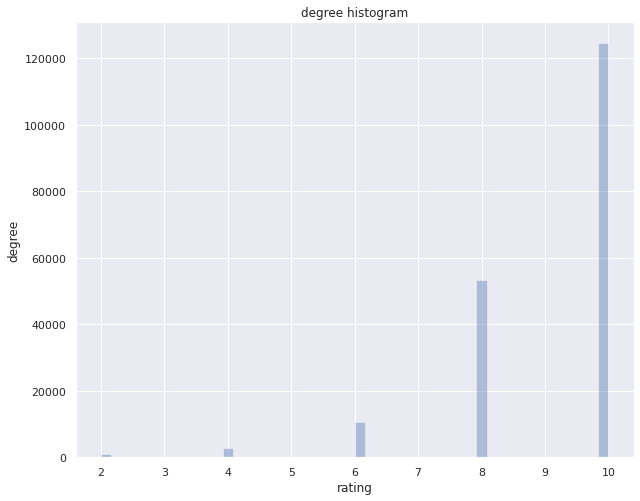

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Rating의 평균값: ", df['rating'].mean()) # Rating 평균이 9점으로 높은 상황, 이에 label을 9점이상은 1 / 9점 이하는 0으로 설정하여 재구매율 성공율을 퍼펙트한 상품에 대해서만 실시코자 함

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('seaborn-darkgrid')

sns.set(color_codes=True)

ax = sns.distplot(df['rating'], kde=False)

plt.xlabel('rating')
plt.ylabel('degree')
plt.title('degree histogram')

In [262]:
# 10점 rating 만 재구매 시에도 '만족'할 것이라는 기대를 할 수 있을것으로 판단
df['perfect or not']=np.where(df['rating'] < 9.092371481123546,0,1)
df.head()

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not
0,0,2260466,romper,420272,28.0,14,"5' 8""",137lbs,34d,hourglass,vacation,fit,10.0,An adorable romper! Belt and zipper were a lit...,"April 20, 2016",1
1,1,153475,gown,273551,36.0,12,"5' 6""",132lbs,34b,straight & narrow,other,fit,10.0,I rented this dress for a photo shoot. The the...,"June 18, 2013",1
2,2,1063761,sheath,360448,116.0,4,"5' 4""",NaN,NaN,NaN,party,fit,10.0,This hugged in all the right places! It was a ...,"December 14, 2015",1
3,3,126335,dress,909926,34.0,8,"5' 5""",135lbs,34c,pear,formal affair,fit,8.0,I rented this for my company's black tie award...,"February 12, 2014",0
4,4,616682,gown,151944,27.0,12,"5' 9""",145lbs,34b,athletic,wedding,fit,10.0,I have always been petite in my upper body and...,"September 26, 2016",1


In [263]:
df=df.loc[:29999] #3만개로 줄임
df.tail()

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not
29995,29995,509406,dress,857575,35.0,8,"5' 7""",128lbs,32c,athletic,wedding,large,6.0,I found that you couldn't wear a bra with it w...,"December 14, 2016",0
29996,29996,2686402,top,837836,23.0,8,"5' 6""",120lbs,32d,athletic,everyday,fit,10.0,Loved this top because I was able to wear it t...,"July 31, 2017",1
29997,29997,1379493,dress,443304,37.0,20,"5' 3""",140lbs,34b,pear,party,fit,8.0,I rented this dress for my mom's 60th birthday...,"November 7, 2017",0
29998,29998,2255218,blazer,963882,29.0,14,"5' 10""",155lbs,34b,athletic,party,fit,10.0,I wore this for a work event with black pants ...,"April 3, 2017",1
29999,29999,2073013,jumpsuit,539748,46.0,13,"5' 6""",140lbs,36dd,hourglass,other,fit,10.0,"I'm normally a size 6, so the sizing was corre...","June 25, 2017",1


In [264]:
# 우선 review_text를 정제하기
review_s=df[['no.','review_text','perfect or not']]
review_s

,no.,review_text,perfect or not
0,0,An adorable romper! Belt and zipper were a lit...,1
1,1,I rented this dress for a photo shoot. The the...,1
2,2,This hugged in all the right places! It was a ...,1
3,3,I rented this for my company's black tie award...,0
4,4,I have always been petite in my upper body and...,1
...,...,...,...
29995,29995,I found that you couldn't wear a bra with it w...,0
29996,29996,Loved this top because I was able to wear it t...,1
29997,29997,I rented this dress for my mom's 60th birthday...,0
29998,29998,I wore this for a work event with black pants ...,1


In [265]:
print('중복 배제한 유일한 review의 수 :', review_s['review_text'].nunique())

중복 배제한 유일한 review의 수 : 29909


In [266]:
print(review_s['review_text'].isnull().sum()) #리뷰 결측치 확인 -> 0

0


In [ ]:
"""
#stopwords와 punkt 두 개의 zip파일 unzip
!unzip -qq "/root/nltk_data/corpora/punkt.zip"
!unzip -qq "/root/nltk_data/corpora/stopwords.zip"
"""

'\n#stopwords와 punkt 두 개의 zip파일 unzip\n!unzip -qq "/root/nltk_data/corpora/punkt.zip"\n!unzip -qq "/root/nltk_data/corpora/stopwords.zip"\n'

In [267]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [268]:
# NLTK의 불용어
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

#부정어 긍정어 빈도가 겹치지는 단어 불용어에 추가하여 재추출 (1회차에 확인)
stop_words.update(('dress', 'fit', 'size', 'great', 'wore', 'loved', 'little', 'color','got'))

#부정어 긍정어 빈도가 겹치지는 단어 불용어에 추가하여 재추출 (2회차에 확인)
stop_words.update(('would','wear','wearing'))

print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 191
{'ma', 'herself', 'this', 'hadn', "shan't", 'little', 'down', 'here', 'out', "aren't", 'you', 'both', 'y', 'wouldn', 'he', 'how', 'of', 'before', 'over', 'any', "that'll", 'further', 'can', 'more', "you're", 'up', 'loved', 'had', 'so', 'such', 'isn', 'o', 'wore', 'no', 'fit', 'hasn', 'me', 'now', 'd', 'until', 'same', 'having', 'hers', 'while', 'don', 'wear', "you'll", 'is', 'as', 'been', "you've", 'i', 'be', "isn't", 'off', 'she', 'where', 'during', 'its', 'your', 'are', 'only', 'other', 'have', 'didn', 'themselves', 'shouldn', 'own', 'into', 'did', 'am', 'ours', 'too', 'most', 'in', 'we', "hadn't", "she's", 'whom', 'do', 'size', 'myself', 'they', 'does', 'mightn', 'being', 'once', "you'd", 'below', 'under', 'there', 'doesn', 'nor', 'if', 'dress', 'few', 'shan', 'to', 'because', "it's", 'than', 'by', "don't", 'that', 'with', 'were', "mustn't", 'after', 'wasn', "couldn't", 'yourselves', 'who', 'on', 'or', 'theirs', 'their', 'through', 'm', 'needn', 't', 'has', 'color', 'be

In [205]:
# # 전처리 함수 내 사용
# contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [269]:

from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [270]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    # sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [271]:
# Text 열 전처리
clean_text = []
for s in review_s['review_text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['adorable romper belt zipper hard navigate full day bathroom use expected wish pockets absolutely perfect million compliments',
 'rented photo shoot theme hollywood glam big beautiful hats comfortable easy move around definitely list rent another formal event',
 'hugged right places perfect event received many compliments mention customer service getting less hours',
 'rented company black tie awards banquet liked short fancier sequins describe rose gold yellow gold blonde hair fair skin flattering forgiving form fitting without making feel like squeezed rent one highly recommend',
 'always petite upper body extremely athletic typically due fact smaller upper frame cup depends fabric talking however lifting weights back grown lat area wide suffocating muscular back fine recommend go lifting weights broad upper body']

In [272]:
# 위의 전처리된 값 저장
review_s['review_text_2'] = clean_text

In [273]:
# 길이가 공백인 샘플은 NULL 값으로 변환
review_s.replace('', np.nan, inplace=True)
print(review_s.isnull().sum())

no.                0
review_text        0
perfect or not     0
review_text_2     98
dtype: int64


In [274]:
review_s.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(review_s)))

전체 샘플수 : 29902


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 157
텍스트의 평균 길이 : 22.28412815196308


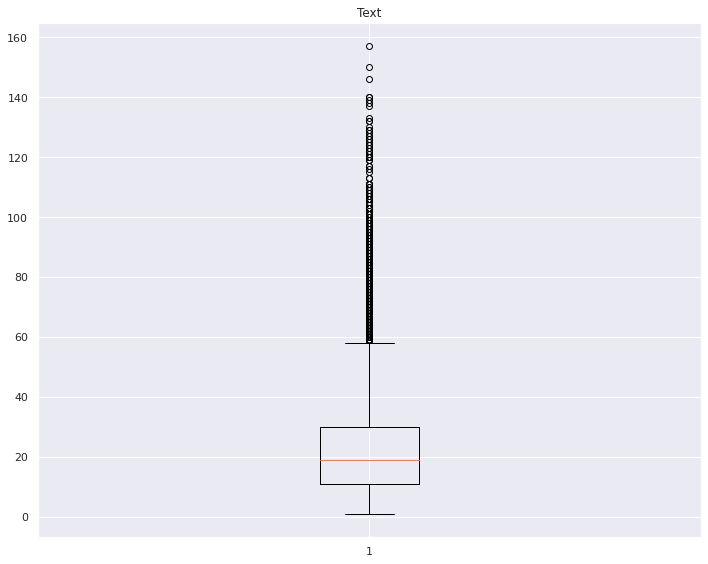

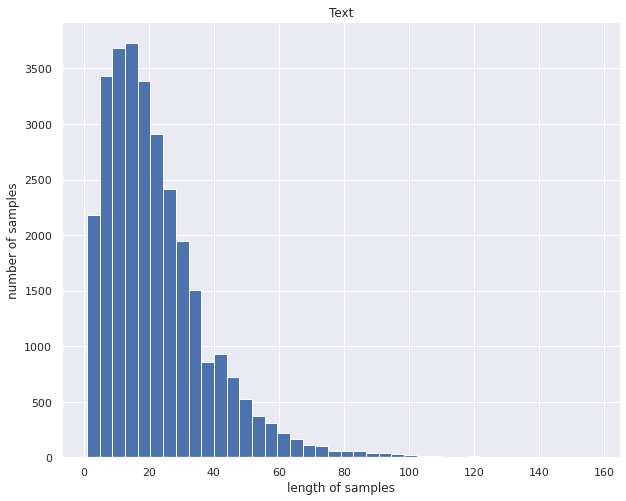

In [275]:
# 길이 분포 출력
text_len = [len(s.split()) for s in review_s['review_text_2']]


print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))



plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [283]:
#텍스트는 대체적으로 100이하의 길이를 가집니다. 또한, 평균 길이는 22입니다. 여기서 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 25으로 합니다.
text_max_len = 29

In [284]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [285]:
below_threshold_len(text_max_len, review_s['review_text_2'])

전체 샘플 중 길이가 29 이하인 샘플의 비율: 0.7451341047421577


In [286]:
# 여기서는 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.
review_s = review_s[review_s['review_text_2'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :',(len(review_s)))

전체 샘플수 : 22281


In [287]:
review_s.head()

,no.,review_text,perfect or not,review_text_2
0,0,An adorable romper! Belt and zipper were a lit...,1,adorable romper belt zipper hard navigate full...
1,1,I rented this dress for a photo shoot. The the...,1,rented photo shoot theme hollywood glam big be...
2,2,This hugged in all the right places! It was a ...,1,hugged right places perfect event received man...
5,5,Didn't actually wear it. It fit perfectly. The...,0,actually perfectly fabric thicker higher quali...
6,6,This dress is so sweet. I loved the print. The...,1,sweet print loose tie waist means flatter figu...


In [288]:
review_s=review_s[['no.','review_text_2','perfect or not']]
review_s

,no.,review_text_2,perfect or not
0,0,adorable romper belt zipper hard navigate full...,1
1,1,rented photo shoot theme hollywood glam big be...,1
2,2,hugged right places perfect event received man...,1
5,5,actually perfectly fabric thicker higher quali...,0
6,6,sweet print loose tie waist means flatter figu...,1
...,...,...,...
29994,29994,normally go one right think fine regular inste...,1
29995,29995,found bra see sections zipper slightly deforme...,0
29996,29996,top able work slacks throw shorts heels later ...,1
29998,29998,work event black pants heels perfect blazer ea...,1


In [289]:
from sklearn.model_selection import train_test_split

#훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(review_s, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 16710
테스트용 리뷰의 개수 : 5571


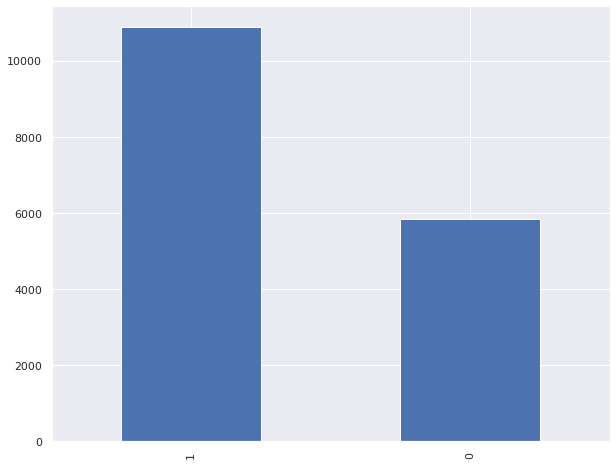

In [290]:
train_data['perfect or not'].value_counts().plot(kind = 'bar') #63% 가 PERFECT

In [31]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 65.8 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-11-11 00:38:40--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [291]:
from konlpy.tag import Mecab
#train/test 데이터 토큰화
mecab = Mecab()
train_data['tokenized'] = train_data['review_text_2'].apply(mecab.morphs)
test_data['tokenized'] = test_data['review_text_2'].apply(mecab.morphs)

In [292]:
X_train = train_data['tokenized'].values
y_train = train_data['perfect or not'].values
X_test= test_data['tokenized'].values
y_test = test_data['perfect or not'].values

In [293]:
negative_words = np.hstack(train_data[train_data['perfect or not'] == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data['perfect or not'] == 1]['tokenized'].values)

In [294]:
from collections import Counter

#부정어 빈도
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(30))

[('comfortable', 942), ('bit', 882), ('really', 797), ('tight', 783), ('long', 765), ('compliments', 760), ('top', 731), ('like', 725), ('perfect', 708), ('short', 706), ('small', 702), ('beautiful', 639), ('fabric', 627), ('back', 614), ('well', 603), ('material', 579), ('big', 575), ('large', 555), ('flattering', 550), ('definitely', 544), ('pretty', 543), ('length', 534), ('overall', 528), ('work', 514), ('waist', 506), ('cute', 501), ('look', 462), ('night', 461), ('still', 454), ('could', 449)]


In [295]:
#긍정어 빈도
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(30))

[('perfect', 2921), ('comfortable', 2598), ('compliments', 2430), ('definitely', 1389), ('flattering', 1320), ('length', 1318), ('night', 1304), ('rent', 1268), ('long', 1217), ('like', 1188), ('true', 1170), ('beautiful', 1150), ('bit', 1107), ('many', 1104), ('bra', 1084), ('received', 1069), ('really', 1014), ('recommend', 1013), ('heels', 999), ('tight', 988), ('wedding', 984), ('well', 983), ('perfectly', 979), ('back', 962), ('felt', 948), ('fabric', 941), ('love', 934), ('top', 923), ('material', 875), ('short', 872)]


In [296]:
#이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [297]:
#단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다.
#이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7706
등장 빈도가 1번 이하인 희귀 단어의 수: 3106
단어 집합에서 희귀 단어의 비율: 40.30625486633792
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2592589589423198


In [298]:
#아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4602


In [299]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [300]:
print(X_train[:3])

[[275, 23, 48, 10, 102, 45, 100, 35, 185, 3, 185, 158, 177, 61, 178, 26, 81, 2, 25, 144, 4, 336, 900, 268, 102, 40, 260, 127, 650], [5, 93, 9, 288, 775, 36, 56, 265, 182], [393, 470, 598, 85, 268, 3, 162, 14, 30, 1873, 726, 22, 86, 20, 183]]


In [301]:
print(X_test[:3])

[[18, 314, 12, 24, 109, 182, 49, 17, 37, 224, 9, 595, 7, 16], [1379, 2935, 308, 477, 554, 70, 739, 912, 224], [359, 309, 48, 34, 47, 97, 106, 1013, 35, 90, 2809, 52, 443, 723, 445, 63, 686, 301, 2598, 325, 1143, 3391, 4408]]


In [302]:
X_train = pad_sequences(X_train, maxlen = 30)
X_test = pad_sequences(X_test, maxlen = 30)

In [303]:
#GRU로 리뷰 감성 분류하기
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [304]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) #adam 일때는 loss: loss: 0.3470 - acc: 0.8499 - val_loss: 0.6808 - val_acc: 0.7006/ test는 loss: 0.6152 - acc: 0.7081
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
209/209 [==============================] - ETA: 0s - loss: 0.5791 - acc: 0.6978
Epoch 00001: val_acc improved from -inf to 0.72890, saving model to best_model.h5
209/209 [==============================] - 18s 72ms/step - loss: 0.5791 - acc: 0.6978 - val_loss: 0.5329 - val_acc: 0.7289
Epoch 2/15
209/209 [==============================] - ETA: 0s - loss: 0.5078 - acc: 0.7545
Epoch 00002: val_acc improved from 0.72890 to 0.73908, saving model to best_model.h5
209/209 [==============================] - 15s 70ms/step - loss: 0.5078 - acc: 0.7545 - val_loss: 0.5201 - val_acc: 0.7391
Epoch 3/15
209/209 [==============================] - ETA: 0s - loss: 0.4760 - acc: 0.7755
Epoch 00003: val_acc improved from 0.73908 to 0.74207, saving model to best_model.h5
209/209 [==============================] - 14s 69ms/step - loss: 0.4760 - acc: 0.7755 - val_loss: 0.5303 - val_acc: 0.7421
Epoch 4/15
209/209 [==============================] - ETA: 0s - loss: 0.4484 - acc: 0.7954
Epoch 00004: va

In [305]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

175/175 [==============================] - 2s 11ms/step - loss: 0.5658 - acc: 0.7155

 테스트 정확도: 0.7155


In [306]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 30) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  return score
  # if(score > 0.5):
  #   print("{:.2f}% 확률로 퍼펙트 리뷰입니다.".format(score * 100))
  #   print(score)
  # else:
  #   print("{:.2f}% 확률로 no-퍼펙트 리뷰입니다.".format((1 - score) * 100))
  #   print(score)

In [307]:
sentiment_predict("i love it ") 

0.8507553935050964

In [308]:
sentiment_predict("i dislike dress ") 

0.5426753163337708

In [309]:
sentiment_predict("i don't want ") 

0.855259358882904

In [311]:
sentiment_predict("fuck you") 

0.6630551218986511

In [312]:
sentiment_predict("not fit") 

0.4805765450000763

In [313]:
Predict_Perfect = []
for i in review_s['review_text_2']:
    pred = sentiment_predict(i)
    Predict_Perfect.append(pred)
review_s["Predict_Perfect"] = Predict_Perfect

review_s.head()

,no.,review_text_2,perfect or not,Predict_Perfect
0,0,adorable romper belt zipper hard navigate full...,1,0.924664
1,1,rented photo shoot theme hollywood glam big be...,1,0.936714
2,2,hugged right places perfect event received man...,1,0.937935
5,5,actually perfectly fabric thicker higher quali...,0,0.848586
6,6,sweet print loose tie waist means flatter figu...,1,0.847270


In [ ]:
# from textblob import TextBlob
# from tqdm import tqdm

# reviews = review_s['review_text_2']

# Predict_Sentiment = []
# for review in tqdm(reviews):
#     blob = TextBlob(review)
#     Predict_Sentiment += [blob.sentiment.polarity]
# review_s["Predict_Sentiment"] = Predict_Sentiment

# review_s.head()

In [ ]:
# import matplotlib.pyplot as plt

# # Create count of the number of epochs
# epoch_count = range(1, len(history.history['loss']) + 1)

# # Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
# #As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
# #on accuracy and learning curve.
# plt.plot(epoch_count, history.history['loss'], 'r--')
# plt.plot(epoch_count, history.history['val_loss'], 'b-')
# plt.legend(['Training Loss', 'Validation Loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# df_all['date'] = pd.to_datetime(df_all['date'])
# df_all['day'] = df_all['date'].dt.day
# df_all['year'] = df_all['date'].dt.year
# df_all['month'] = df_all['date'].dt.month

In [ ]:
# 모델 성능 확인을 마지막으로 진행

In [314]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [315]:
df2 = pd.merge(df, review_s[['no.','Predict_Perfect']], on='no.') 
df2.head()

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
0,0,2260466,romper,420272,28.0,14,"5' 8""",137lbs,34d,hourglass,vacation,fit,10.0,An adorable romper! Belt and zipper were a lit...,"April 20, 2016",1,0.924664
1,1,153475,gown,273551,36.0,12,"5' 6""",132lbs,34b,straight & narrow,other,fit,10.0,I rented this dress for a photo shoot. The the...,"June 18, 2013",1,0.936714
2,2,1063761,sheath,360448,116.0,4,"5' 4""",NaN,NaN,NaN,party,fit,10.0,This hugged in all the right places! It was a ...,"December 14, 2015",1,0.937935
3,5,364092,dress,734848,45.0,8,"5' 8""",138lbs,32b,athletic,date,fit,8.0,Didn't actually wear it. It fit perfectly. The...,"April 30, 2016",0,0.848586
4,6,568429,dress,336066,27.0,4,"5' 3""",112lbs,34c,hourglass,everyday,fit,10.0,This dress is so sweet. I loved the print. The...,"December 7, 2017",1,0.847270


In [316]:
np.corrcoef(df2["Predict_Perfect"], df2["perfect or not"])

array([[1.        , 0.56502404],
       [0.56502404, 1.        ]])

In [330]:
df3 = df2.pivot_table(index='user_id', columns = 'item_id', values = 'Predict_Perfect').fillna(0)
df3.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,127865,128730,128959,129831,130259,130727,131117,131533,131698,132135,132738,133584,134015,134393,134849,135459,135750,136110,136860,137585,138431,139086,139792,140321,140877,141300,141548,141688,141761,142179,...,2932879,2934055,2934869,2935830,2935879,2936293,2936514,2936752,2937389,2939236,2940176,2941443,2941958,2942706,2945301,2945782,2946611,2947498,2948324,2949937,2951824,2953681,2953965,2954118,2954754,2955585,2955734,2956453,2957351,2957481,2958376,2959486,2960025,2960913,2960969,2962646,2963344,2963850,2965924,2966087
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.678778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [331]:
R = df3.iloc[:, : ].values

# user_num = R.shape[0]
# item_num = R.shape[1]

In [327]:
R.shape[1]

4259

In [319]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [320]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [332]:
# 학습 조건 설정
BATCH_SIZE = 64
EPOCHS = 10

In [333]:

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.Tensor(self.x_data[idx])
      return x
    else:
      x = torch.Tensor(self.x_data[idx])
      y = torch.Tensor(self.y_data[idx])
      return x, y

In [386]:
drop_prob = 0.5
# AutoEncoder 모델 설계
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(4259, 64),
        nn.Dropout(p=drop_prob),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16)
    )

    self.decoder = nn.Sequential(
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 4259)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [387]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for batch_idx, (feature) in enumerate(train_loader):

    feature = feature.to(DEVICE)
    target = feature.to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(feature)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [388]:

# 모델 정의
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=4259, out_features=64, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4259, bias=True)
  )
)


In [389]:
train_dataset = CustomDataset(R)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")

#학습셋을 늘린다. / Feature의 개수를 줄인다./ Regularization term을 추가한다. / Dropout


[EPOCH: 1], 	Train Loss: 0.0004

[EPOCH: 2], 	Train Loss: 0.0001

[EPOCH: 3], 	Train Loss: 0.0001

[EPOCH: 4], 	Train Loss: 0.0001

[EPOCH: 5], 	Train Loss: 0.0001

[EPOCH: 6], 	Train Loss: 0.0001

[EPOCH: 7], 	Train Loss: 0.0001

[EPOCH: 8], 	Train Loss: 0.0001

[EPOCH: 9], 	Train Loss: 0.0001

[EPOCH: 10], 	Train Loss: 0.0001


In [390]:
def evaluate(model, train_loader):
  model.eval()
  result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      _, decoded = model(feature)
      result.append(decoded.cpu().numpy())

  result = np.concatenate(result)

  return result

result = evaluate(model, train_loader)
result

array([[ 6.5144151e-03,  8.4715188e-03,  6.1537209e-04, ...,
        -9.7727776e-04, -1.0776147e-03,  5.5299432e-04],
       [ 5.1653385e-03,  9.5746890e-03,  8.0125127e-04, ...,
        -1.0090284e-03, -8.5778907e-04, -4.9329340e-04],
       [ 6.1390772e-03,  8.1167128e-03,  1.6021170e-04, ...,
         7.3092058e-04,  2.2928789e-04,  1.8547688e-04],
       ...,
       [ 7.4140318e-03,  7.4995160e-03, -8.4685476e-04, ...,
         4.4507533e-04,  1.0698102e-03, -1.5069181e-04],
       [ 7.0359372e-03,  7.4839834e-03,  3.1062169e-05, ...,
         5.6483224e-04,  2.3132190e-04,  5.1193859e-04],
       [ 5.0001852e-03,  8.4153544e-03,  1.5572864e-03, ...,
        -1.2988076e-03, -1.9341335e-03, -4.3551260e-04]], dtype=float32)

In [391]:
result.shape

(18835, 4259)

In [392]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [393]:
item_li = df3.columns.tolist()
result[R >= 1] = -1

In [394]:
recommend_li = []
for i in result.argmax(axis=1):
  recommend_li.append(item_li[i])

In [395]:
recommend_df = pd.DataFrame()
recommend_df['user_id'] = df3.index.tolist()
recommend_df['ITEM_R'] = recommend_li
recommend_df.head(5)

,user_id,ITEM_R
0,47,174086
1,83,174086
2,97,174086
3,321,126335
4,329,126335


In [ ]:
# 제대로 했는지 고객 정보와 ITEM 정보 비교 (1)

In [374]:
df2[df2['user_id']==47]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
11784,15849,132135,gown,47,29.0,1,"5' 4""",120lbs,34a,pear,formal affair,large,8.0,I ordered a 2R and 0R. I wore the 0R which fit...,"April 29, 2014",0,0.678778


In [396]:
df2[df2['item_id']==174086]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
78,98,174086,dress,428934,36.0,4,"5' 5""",130lbs,32c,pear,wedding,fit,10.0,The dress fit perfectly and looked absoultely ...,"May 28, 2013",1,0.986674
116,155,174086,dress,70197,31.0,1,"5' 3""",NaN,32c,petite,wedding,large,8.0,The dress runs big overall so order a size down.,"October 8, 2014",0,0.296125
346,463,174086,dress,184119,30.0,12,"5' 2""",NaN,34d,petite,date,fit,8.0,I wore this for Valentine's day. It was very p...,"June 30, 2014",0,0.697303
484,647,174086,dress,630618,27.0,12,"5' 2""",NaN,34d,hourglass,wedding,fit,10.0,This dress was amazing! I received so many com...,"January 10, 2014",1,0.975555
723,962,174086,dress,727933,32.0,8,"5' 0""",NaN,34b,hourglass,wedding,fit,10.0,Great dress! I ordered it for a destination we...,"April 20, 2015",1,0.963948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,29250,174086,dress,307536,27.0,12,"5' 4""",135lbs,34b,athletic,wedding,fit,8.0,Perfect for a daytime wedding! Extremely comfo...,"May 13, 2014",0,0.944604
21829,29368,174086,dress,873440,31.0,8,"5' 3""",NaN,34d,hourglass,wedding,fit,10.0,Beautiful color. Beautiful dress.,"May 6, 2014",1,0.798398
21956,29546,174086,dress,324066,29.0,8,"5' 4""",135lbs,34c,apple,wedding,fit,8.0,"Was a little snug in the bust, but fit perfect...","June 21, 2015",0,0.901334
22164,29835,174086,dress,671322,38.0,20,"5' 5""",165lbs,34d,hourglass,wedding,fit,8.0,Dress is perfect for curvy or apple bottom wom...,"May 21, 2014",0,0.483179


In [ ]:
# 제대로 했는지 고객 정보와 ITEM 정보 비교 (2)

In [397]:
df2[df2['user_id']==321]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
2206,2976,452942,dress,321,30.0,1,"5' 3""",112lbs,32c,petite,wedding,fit,10.0,"Fit like a glove, forgiving yet sexy. The back...","November 6, 2017",1,0.967798


In [398]:
df2[df2['item_id']==126335]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
58,72,126335,dress,383116,48.0,4,"5' 8""",128lbs,34d,full bust,formal affair,large,10.0,"I normally wear a 4, but ended up wearing the ...","June 8, 2014",1,0.125969
153,208,126335,dress,88691,38.0,12,"5' 2""",140lbs,34b,pear,wedding,large,10.0,My back-up size for the original dress that I ...,"August 15, 2013",1,0.470645
161,218,126335,dress,423063,23.0,8,"5' 8""",NaN,34c,hourglass,formal affair,fit,8.0,The dress was a perfect fit! The only small is...,"January 28, 2014",0,0.673256
163,221,126335,dress,67602,42.0,16,"5' 6""",150lbs,NaN,hourglass,other,fit,10.0,"I normally wear a 6, but the 6 was squishing m...","January 16, 2015",1,0.785084
168,226,126335,dress,603555,35.0,8,"5' 9""",NaN,34a,athletic,wedding,fit,8.0,"comfortable, great fit.","August 11, 2014",0,0.708128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21637,29117,126335,dress,644715,36.0,28,"5' 5""",180lbs,38c,apple,party,fit,8.0,I am so glad I rented this dress! It was the ...,"September 2, 2014",0,0.369512
21650,29133,126335,dress,521993,38.0,24,"5' 7""",185lbs,38d,hourglass,other,fit,10.0,Had to pin the top together as I wore it to a ...,"December 9, 2013",1,0.525273
21906,29479,126335,dress,998391,34.0,16,"5' 7""",NaN,34b,hourglass,formal affair,fit,4.0,"If you have even a little bit of tummy, don't ...","March 18, 2014",0,0.572053
22076,29710,126335,dress,404832,40.0,35,"5' 4""",220lbs,38d,pear,party,fit,8.0,was a back up dress and would of worn it but d...,"December 27, 2017",0,0.393804


In [399]:
rented_num=df['no.'].groupby(df['user_id']).count()
rented_num

user_id
44        1
47        1
83        1
97        1
321       1
         ..
999865    1
999910    2
999913    1
999952    1
999994    1
Name: no., Length: 24767, dtype: int64

In [400]:
rented_num.sort_values(ascending=False)

user_id
691468    70
32925     47
362951    40
45337     32
833675    28
          ..
650067     1
650178     1
650184     1
650363     1
44         1
Name: no., Length: 24767, dtype: int64

In [ ]:
# 제대로 했는지 고객 정보와 ITEM 정보 비교, rent 이력 많은 사람 (3)

In [401]:
df2[df2['user_id']==691468]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
1047,1401,326908,dress,691468,31.0,4,"5' 3""",125lbs,34c,full bust,everyday,large,10.0,"i'm typically btwn 2 and 4, usually 2 in erin....","July 20, 2016",1,0.855361
1852,2494,1754771,gown,691468,31.0,8,"5' 3""",125lbs,34c,full bust,formal affair,large,6.0,i didn't end up wearing this dress because it ...,"May 18, 2015",0,0.108494
3052,4117,1620318,dress,691468,31.0,8,"5' 3""",125lbs,34c,full bust,vacation,fit,8.0,i'm typically btwn a 2 and a 4 and the small f...,"September 2, 2015",0,0.888440
3565,4811,1138140,dress,691468,31.0,4,"5' 3""",125lbs,34c,full bust,date,large,10.0,loved the color and the style was perfect for ...,"December 7, 2017",1,0.936859
5261,7111,1788074,dress,691468,31.0,4,"5' 3""",125lbs,34c,full bust,work,large,8.0,"typically btwn a 2 and a 4, got the 2 based on...","May 19, 2016",0,0.348663
5397,7295,944012,dress,691468,31.0,8,"5' 3""",125lbs,34c,full bust,everyday,small,2.0,i should've listened to the other reviews. i a...,"October 30, 2015",0,0.032131
6496,8766,1084380,dress,691468,31.0,8,"5' 3""",125lbs,34c,full bust,work,fit,8.0,"very comfortable, easy to wear pattern, the sl...","November 1, 2016",0,0.193814
7119,9612,1756956,dress,691468,31.0,4,"5' 3""",125lbs,34c,full bust,date,large,10.0,"i'm typically a 4, but always a 2 in josie nat...","September 6, 2017",1,0.978645
8001,10811,230856,dress,691468,31.0,8,"5' 3""",125lbs,34c,full bust,everyday,large,8.0,print is great and versatile. i'm usually a 4 ...,"December 15, 2016",0,0.365598
8473,11452,2203043,shirt,691468,31.0,8,"5' 3""",125lbs,34c,full bust,everyday,large,10.0,great color and style. i'm typically a 4 or sm...,"June 1, 2017",1,0.543768


In [402]:
recommend_df[recommend_df['user_id']==691468]

,user_id,ITEM_R
12933,691468,174086


In [403]:
df2[df2['item_id']==174086]

,no.,item_id,category,user_id,age,size,height,weight,bust size,body type,rented for,fit,rating,review_text,review_date,perfect or not,Predict_Perfect
78,98,174086,dress,428934,36.0,4,"5' 5""",130lbs,32c,pear,wedding,fit,10.0,The dress fit perfectly and looked absoultely ...,"May 28, 2013",1,0.986674
116,155,174086,dress,70197,31.0,1,"5' 3""",NaN,32c,petite,wedding,large,8.0,The dress runs big overall so order a size down.,"October 8, 2014",0,0.296125
346,463,174086,dress,184119,30.0,12,"5' 2""",NaN,34d,petite,date,fit,8.0,I wore this for Valentine's day. It was very p...,"June 30, 2014",0,0.697303
484,647,174086,dress,630618,27.0,12,"5' 2""",NaN,34d,hourglass,wedding,fit,10.0,This dress was amazing! I received so many com...,"January 10, 2014",1,0.975555
723,962,174086,dress,727933,32.0,8,"5' 0""",NaN,34b,hourglass,wedding,fit,10.0,Great dress! I ordered it for a destination we...,"April 20, 2015",1,0.963948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,29250,174086,dress,307536,27.0,12,"5' 4""",135lbs,34b,athletic,wedding,fit,8.0,Perfect for a daytime wedding! Extremely comfo...,"May 13, 2014",0,0.944604
21829,29368,174086,dress,873440,31.0,8,"5' 3""",NaN,34d,hourglass,wedding,fit,10.0,Beautiful color. Beautiful dress.,"May 6, 2014",1,0.798398
21956,29546,174086,dress,324066,29.0,8,"5' 4""",135lbs,34c,apple,wedding,fit,8.0,"Was a little snug in the bust, but fit perfect...","June 21, 2015",0,0.901334
22164,29835,174086,dress,671322,38.0,20,"5' 5""",165lbs,34d,hourglass,wedding,fit,8.0,Dress is perfect for curvy or apple bottom wom...,"May 21, 2014",0,0.483179


In [414]:
item_rented_num=df2['no.'].groupby(df2['item_id']).count()
item_rented_num

item_id
123373      63
123793     170
124204      78
124553      63
125424      59
          ... 
2962646      1
2963344      1
2963850      2
2965924      1
2966087      1
Name: no., Length: 4259, dtype: int64

In [417]:
item_rented_num.sort_values(ascending=False).head(425).sum()

10580

In [416]:
df2.shape #10%에 해당하는 제품수가 전체 rent건의 50% 비중을 차지 => 잘 팔리는 상품이 아닌 '사용자 선호도' / '상황에 적합한' 에 대한 추천구조를 만들어야 해야 할 것

(22281, 17)

In [ ]:
# features_idx = []
# for i in range(user_num):
#   for j in range(item_num):
#     features_idx.append([i, j])

In [ ]:
# features = np.transpose(R.nonzero()).tolist()

In [ ]:
# labels = []

# for i, j in features:
#   labels.append(R[i, j])

In [ ]:
# class GMF_and_MLP(nn.Module):
#   def __init__(self, user_num, item_num, factor_num, num_layers = 3):
#       super(GMF_and_MLP, self).__init__()

#       # GMF 임베딩
#       self.GMF_user_embedding = nn.Embedding(user_num, factor_num)
#       self.GMF_item_embedding = nn.Embedding(item_num, factor_num)

#       # MLP 임베딩
#       self.MLP_user_embedding = nn.Embedding(user_num, factor_num)
#       self.MLP_item_embedding = nn.Embedding(item_num, factor_num)

#       MLP_modules = []
#       input_size = factor_num * 2
#       for i in range(num_layers):
#         MLP_modules.append(nn.Linear(input_size, input_size // 2))
#         MLP_modules.append(nn.ReLU())
#         input_size //=  2
#       self.MLP_layers = nn.Sequential(*MLP_modules)

#       # FC
#       self.FC_layer = nn.Sequential(
#           nn.Linear(factor_num + input_size, 1)
#       )
#       self._init_weight_()

#   def _init_weight_(self):
#       # weight 초기화
#       nn.init.normal_(self.GMF_user_embedding.weight, std=0.01)
#       nn.init.normal_(self.GMF_item_embedding.weight, std=0.01)
#       nn.init.normal_(self.MLP_user_embedding.weight, std=0.01)
#       nn.init.normal_(self.MLP_item_embedding.weight, std=0.01)

#       for m in self.MLP_layers:
#           if isinstance(m, nn.Linear):
#               nn.init.xavier_uniform_(m.weight)

#       for m in self.FC_layer:
#           if isinstance(m, nn.Linear):
#               nn.init.xavier_uniform_(m.weight)

#   def forward(self, user, item):
#       GMF_user_embedding = self.GMF_user_embedding(user)
#       GMF_item_embedding = self.GMF_item_embedding(item)

#       output_GMF = (GMF_user_embedding * GMF_item_embedding)

#       MLP_user_embedding = self.MLP_user_embedding(user)
#       MLP_item_embedding = self.MLP_item_embedding(item)

#       concat_two_latent_vactors = torch.cat((MLP_user_embedding, MLP_item_embedding), -1)
#       output_MLP = self.MLP_layers(concat_two_latent_vactors)

#       concat_GMF_MLP = torch.cat((output_GMF, output_MLP), -1)

#       out = self.FC_layer(concat_GMF_MLP)
#       out = out.view(-1)

#       return out

In [ ]:
# model = GMF_and_MLP(user_num = user_num, item_num = item_num, factor_num = 20).to(DEVICE)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# class NCFData(data.Dataset):
#     def __init__(self, features, labels = None):
#         super(NCFData, self).__init__()
#         self.features = features
#         self.labels = labels

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):

#       if self.labels is not None:
#         user = self.features[idx][0]
#         item = self.features[idx][1]
#         label = self.labels[idx]

#         return user, item, label

#       else: 
#         user = self.features[idx][0]
#         item = self.features[idx][1]
#         return user, item

In [ ]:

# def train(model, train_loader):
#   model.train()
#   train_loss = 0
#   for user, item, label in train_loader:
#     user = user.to(DEVICE)
#     item = item.to(DEVICE)
#     label = label.float().to(DEVICE)
#     optimizer.zero_grad()
#     output = model(user, item)
#     loss = criterion(output, label)
#     loss.backward()
#     optimizer.step()

#     train_loss += loss.item()

#   train_loss /= len(train_loader)
#   return train_loss

In [ ]:
# def predict(model, loader):
#   model.eval()
#   result = []
#   with torch.no_grad():
#     for user, item in loader:
#       user = user.to(DEVICE)
#       item = item.to(DEVICE)
#       output = model(user, item)
#       result.append(output.view(-1))

#   return result

In [ ]:
# train_dataset = NCFData(features, labels)
# train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

# for epoch in range(1, EPOCHS + 1):
#   train_loss = train(model, train_loader)
#   print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")

In [ ]:
# dataset = NCFData(features_idx)
# loader = data.DataLoader(dataset, batch_size = BATCH_SIZE)
# pred = predict(model, loader)
# pred = torch.cat(pred).view(user_num, item_num)

In [ ]:
# pred